# Исследование надежности заемщиков

## Шаг 1. Обзор данных

Импортируем используемые в проекте библиотеки и загружаем .csv

In [1]:
import pandas as pd
import numpy as np

In [2]:
try:
    df = pd.read_csv('***/data.csv')
    df.head()
except:
    print('Не удалось загрузить файл, проверьте путь.')

## Шаг 2.Предобработка данных

### Шаг 2.1 Заполнение пропусков

Определим долю пропущенные значения в каждом из столбцов с пропусками.

<AxesSubplot:>

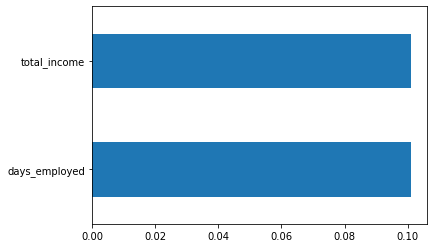

In [3]:
is_null_list = df.isna().mean().sort_values(ascending=False)
is_null_list[is_null_list > 0].plot.barh()

Пропуски есть в days_employed и total_income. Их значения равны и составляют 10%. и total_income. Их значения равны и составляют 10%.

In [4]:
# Проверяем есть ли строки в которых days_employed и total_income не являются NaN одновременно.
df[(df.days_employed.isna()) & (df.total_income.isna() == False)].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


Очевидно что NaN в колоннах связаны. У людей без заработка (пенсионер и т.п.) и в days_employed указан NaN.

<div class="alert alert-success">Медианные значения более устойчивы к выбросам чем средние значения, поэтому для количественных переменных используют их.</div>

Заполним пропущенные значения медианным значением по столбцу с учетом категории income_type.

In [5]:
df.total_income = df.total_income.fillna(df.groupby(['education','income_type'])['total_income'].transform('median'))
df.days_employed = df.days_employed.fillna(df.groupby(['education','income_type'])['days_employed'].transform('median'))

# Результат выполненной операции - пропусков больше нет.
df.isna().sum().sum()

0

### Шаг 2.3. Изменение типов данных.

Выведем общие данные по фрейму:

In [6]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,2.152500e+04
mean,0.538908,63551.101784,43.293380,0.817236,0.972544,0.080883,1.653759e+05
std,1.381587,141154.503593,12.574584,0.548138,1.420324,0.272661,9.816425e+04
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2566.981734,33.000000,1.000000,0.000000,0.000000,1.077142e+05
50%,0.000000,-1342.072911,42.000000,1.000000,0.000000,0.000000,1.431116e+05
75%,1.000000,-316.240646,53.000000,1.000000,1.000000,0.000000,1.981056e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [7]:
df.describe(exclude=np.number)

,education,family_status,gender,income_type,purpose
count,21525,21525,21525,21525,21525
unique,15,5,3,8,38
top,среднее,женат / замужем,F,сотрудник,свадьба
freq,13750,12380,14236,11119,797


Выявленные артефакты:
- children: минимум равен -1 и максимум аж 20.
- days_employed: отрицательные, дробные и слишком большие значения.
- dob_years: возраст клиента 0.
- gender: выявлен третий гендер.

Посмотрим на данные в которых есть аномалии.

In [8]:
df[df.days_employed < 0].sample(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
7101,0,-1641.324632,51,среднее,1,женат / замужем,0,M,сотрудник,0,85644.678836,строительство собственной недвижимости
8319,0,-109.342362,53,среднее,1,Не женат / не замужем,4,M,сотрудник,0,124770.017063,операции с жильем
20370,1,-2621.903545,39,среднее,1,женат / замужем,0,F,сотрудник,0,144832.645057,на покупку автомобиля


In [9]:
df[df.children < 0].sample(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
7685,-1,-3237.360455,53,среднее,1,вдовец / вдова,2,F,сотрудник,0,159676.174958,строительство жилой недвижимости
16129,-1,-457.861760,33,среднее,1,женат / замужем,0,F,сотрудник,1,149641.079451,автомобиль
11109,-1,-3438.463024,59,среднее,1,женат / замужем,0,F,сотрудник,0,219874.012345,операции с жильем


У 76 человек 20 детей. Явная ошибка.

In [10]:
df.value_counts('children')

children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
dtype: int64

Обратится за кредитом в 0 лет тоже странно, такого быть не может.

In [11]:
df[df.dob_years == 0].sample(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4064,1,-1645.331963,0,среднее,1,гражданский брак,1,M,компаньон,0,159652.900458,ремонт жилью
3147,2,-906.519446,0,высшее,0,женат / замужем,0,F,компаньон,0,215477.004597,операции с жильем
14608,0,-1641.341284,0,среднее,1,гражданский брак,1,M,сотрудник,1,129945.107346,сыграть свадьбу


Аномалии в children и dob_years вероятно вызваны отсутствием данных по клиентам. Можно заменить медианными значениями.

In [12]:
# Видно, что days_employed коррелирует dob_years, а значит значения в столюце имеются смысл, но какой понять не удалось.
df.corr()['days_employed'].sort_values(ascending=False)

days_employed       1.000000
dob_years           0.581618
education_id        0.081911
family_status_id    0.005847
debt               -0.041161
children           -0.137149
total_income       -0.143151
Name: days_employed, dtype: float64

In [13]:
# Сначала заменяем неправильные значения на NaN, а потом применяем заполнение (для replace() такого нет)
df.children = df.children.replace(-1, np.nan).replace(20, np.nan)
df.children = df.children.fillna(df.groupby(['family_status', 'education'])['children'].transform('median')).astype(int)
df.dob_years = df.dob_years.replace(0, np.nan)
df.dob_years = df.dob_years.fillna(df.groupby(['family_status', 'education'])['dob_years'].transform('median')).astype(int)

In [14]:
# Делаем повторную проверку на NaN
df.isna().sum().sum()

0

In [15]:
# Заменим вещественный тип данных в столбце total_income
df.total_income = df.total_income.astype(int)

### Шаг 2.4. Удаление дубликатов.

Определим категориальные переменные.

In [16]:
qualitative = list(df.describe(include='object').columns)
qualitative

['education', 'family_status', 'gender', 'income_type', 'purpose']

Применим lower() ко всем данным содержащим строки (object).

In [17]:
df[qualitative] = df[qualitative].applymap(str.lower)

Пройдемся по датафрейму и найдем уникальные значения для каждой категории.

In [18]:
df.education.unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [19]:
df.family_status.unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

In [20]:
df.income_type.unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

In [21]:
df.purpose.unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Как видим, только в purpose много неявных дубликатов.

<div class="alert alert-success">Осовная проблема появления неявных дубликатов в том что сотрудники или клиенты набирают строки вручную, должна быть возмоность выбора категории только из списка. Тогда проблема бы сошла на нет.</div>

Подсчитаем число явных дубликатов и удалим их:

In [22]:
print(f'Дубликатов до удаления: {df.duplicated().sum()}')
df = df.drop_duplicates().reset_index(drop=True)

Дубликатов до удаления: 54


### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Создадим новые датафреймы.

In [23]:
education_df = df[['education','education_id']]
family_status_df = df[['family_status','family_status_id']]

Удалим из исходного датафрейма столбцы education и family_status.

In [24]:
df = df.drop(columns=['education','family_status'])

### Шаг 2.6. Категоризация дохода.

Получим новый столбец total_income_category с категориями.

In [25]:
# Зададим bins для разбиения total_income и определим лейблы.
bins = [0, 30000, 50000, 200000, 1000000, np.infty]
labels = ['E','D','C','B','A']
df['total_income_category'] = pd.cut(df.total_income, bins=bins, labels=labels)

df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,-8437.673028,42,0,0,f,сотрудник,0,253875,покупка жилья,B
1,1,-4024.803754,36,1,0,f,сотрудник,0,112080,приобретение автомобиля,C
2,0,-5623.422610,33,1,0,m,сотрудник,0,145885,покупка жилья,C
3,3,-4124.747207,32,1,0,m,сотрудник,0,267628,дополнительное образование,B
4,0,340266.072047,53,1,1,f,пенсионер,0,158616,сыграть свадьбу,C


### Шаг 2.7. Категоризация целей кредита.

Создадим список уникальных значений purpose.

In [26]:
purpose_full = df.purpose.unique()

Сформируем лист категорий (сокращений) по которым будем производить поиск.

In [27]:
# Проверка идет сверху вниз, поэтому бизнес расположен выше
cat_list = {'бизнес': ['коммерческ', 'нежил', 'сдач', 'операц'], # выделил отдельно
            'операции с автомобилем': ['авто','машин','транспор'],
            'операции с недвижимостью': ['жилья', 'жилье', 'недвиж', 'строительств', 'квартир', 'ремонт'],
            'получение образования': ['образован'],
            'проведение свадьбы': ['свадьб']
}

В соответствии с алгоритмом заполним словарь correction_list (значение для правки : категория).

In [28]:
# Зададим лист с помощью которого потом внесем правки в purpose
correction_list = {}
# Проходим по листу purpose_full чтобы создать связку ключ-значение (значение для правки : категория)
for purpose in purpose_full:
    for cat_key, cat_val in cat_list.items():
        for word in cat_val:
            # Если поиск выдает -1, то часть слова в строке не найдена иначе меняем категорию
            if purpose.find(word) != -1:
                correction_list[purpose] = cat_key
                break
        # Чтобы не спускаться ниже по списку и сохранить категорию (бизнес).      
        if correction_list.get(purpose) is not None: break
    # Если не получилось заменить purpose на категорию из cat_list, то добавляем оригинальное значение в словарь correction_list
    # и выводим его на экран
    if correction_list.get(purpose) is None:
        correction_list[purpose] = purpose
        print(purpose)

In [29]:
# Формируем новый столбец purpose_category
df['purpose_category'] = df.purpose.map(correction_list)
df.purpose_category.unique()

array(['операции с недвижимостью', 'операции с автомобилем',
       'получение образования', 'проведение свадьбы', 'бизнес'],
      dtype=object)

## Ответы на вопросы

### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

- Сложно сказать однозначно, так как debt (задолженность по возврату кредитов) могла возникнуть в момент когда детей не было, а сейчас они есть и debt уже часть кредитной истории.
- Заёмщики без детей платят лучше, но возможно это просто их первый кредит и у них не успела образоваться задолженность.
- Мужчины, у которых 2-3 ребенка самые надежные. А женщины в целом более ответственно относятся к взятым кредитным обязательствам.

In [30]:
df.pivot_table(index='children', values='debt', aggfunc=['count','mean']).reset_index()

,children,count,mean
,,debt,debt
0,0,14230,0.075334
1,1,4809,0.092327
2,2,2052,0.094542
3,3,330,0.081818
4,4,41,0.097561
5,5,9,0.000000


In [31]:
df.pivot_table(index='children', columns='gender', values='debt', aggfunc=['count','mean']).reset_index()

children   count                   mean               
gender                f       m  xna         f         m  xna
0             0  9616.0  4613.0  1.0  0.062084  0.102970  0.0
1             1  3086.0  1723.0  NaN  0.079391  0.115496  NaN
2             2  1256.0   796.0  NaN  0.106688  0.075377  NaN
3             3   196.0   134.0  NaN  0.086735  0.074627  NaN
4             4    28.0    13.0  NaN  0.035714  0.230769  NaN
5             5     7.0     2.0  NaN  0.000000  0.000000  NaN

### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?

- Люди с family_status_id 3 самые благонадежные. В то время как family_status_id 1 и 4 имеют чуть более высокую тенденцию к невозврату кредита

In [32]:
df.pivot_table(index='family_status_id', values='debt', aggfunc=['count','mean']).reset_index()

,family_status_id,count,mean
,,debt,debt
0,0,12344,0.075421
1,1,4163,0.093202
2,2,959,0.065693
3,3,1195,0.071130
4,4,2810,0.097509


### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

- Клиенты с минимальным доходом ожидаемо показывают худший результат, но их всего 22 человека.
- В то время как категория *D* не допускает просроченных задолженностей.
- У большей части клиентов банка (категория *С*) второй результат по проблемам с долгами.

In [33]:
df.pivot_table(index='total_income_category', values='debt', aggfunc=['count','mean']).reset_index()

,total_income_category,count,mean
,,debt,debt
0,E,22,0.090909
1,D,350,0.060000
2,C,15850,0.085300
3,B,5224,0.069678
4,A,25,0.080000


### Вопрос 4: Как разные цели кредита влияют на его возврат в срок?

- С недвижимость проблем меньше всего, а кредиты под авто и образования могут стать невозвратными.

In [34]:
df.groupby('purpose_category').agg({'debt': ['count', 'mean']}).reset_index()

purpose_category  debt          
                            count      mean
0                    бизнес  3918  0.077591
1    операции с автомобилем  4308  0.093547
2  операции с недвижимостью  6896  0.069316
3     получение образования  4014  0.092177
4        проведение свадьбы  2335  0.079657

Прежде чем давать вывод, рассмотрим ещё замисимость debt от возраста заёмщика.
- Из таблицы следует четкая зависимость - с возрастом клиенты становятся более надёжными.

In [35]:
# Зададим bins для разбиения dob_years и определим лейблы.
bins = [17, 35, 40, 65,  np.infty]
labels = ['VY','Y','M','O']
df['dob_years_category'] = pd.cut(df.dob_years, bins=bins, labels=labels)
df.pivot_table(index='dob_years_category', values='debt', aggfunc=['count','mean']).reset_index()

,dob_years_category,count,mean
,,debt,debt
0,VY,6597,0.105806
1,Y,2893,0.087452
2,M,11277,0.066950
3,O,704,0.049716


## Общий вывод:

1. **В результате исследования получены данные по надежности заемщиков в зависимости от гендера, уровня дохода, возрастной группы и цели кредита.**
2. **Введены новые, удобные категории.**
3. **Данные очищенны от дубликатов и пропусков.**
4. **Выявлена проблема со столбцом days_employed. Требуется уточнение формата или причина ошибки**